# Custom Code Executor

In this guide we will show you how to create a custom code executor that runs
code inside the same Jupyter notebook as this one.

First, let's install the required dependencies:

In [1]:
! pip -qqq install autogen-agentchat~=0.2 matplotlib yfinance

In [11]:
import os
from typing import List

from IPython import get_ipython

from autogen import ConversableAgent
from autogen.coding import CodeBlock, CodeExecutor, CodeExtractor, CodeResult, MarkdownCodeExtractor

Now we can create the custom code executor class by subclassing the
`CodeExecutor` protocol and implementing the `execute_code_blocks` method.

In [9]:
class NotebookExecutor(CodeExecutor):

    @property
    def code_extractor(self) -> CodeExtractor:
        # Extact code from markdown blocks.
        return MarkdownCodeExtractor()

    def __init__(self) -> None:
        # Get the current IPython instance running in this notebook.
        self._ipython = get_ipython()

    def execute_code_blocks(self, code_blocks: List[CodeBlock]) -> CodeResult:
        log = ""
        for code_block in code_blocks:
            result = self._ipython.run_cell("%%capture --no-display cap\n" + code_block.code)
            log += self._ipython.ev("cap.stdout")
            log += self._ipython.ev("cap.stderr")
            if result.result is not None:
                log += str(result.result)
            exitcode = 0 if result.success else 1
            if result.error_before_exec is not None:
                log += f"\n{result.error_before_exec}"
                exitcode = 1
            if result.error_in_exec is not None:
                log += f"\n{result.error_in_exec}"
                exitcode = 1
            if exitcode != 0:
                break
        return CodeResult(exit_code=exitcode, output=log)

Now we can use the new custom code executor in our agents.

In [21]:
code_writer_agent = ConversableAgent(
    name="CodeWriter",
    system_message="You are a helpful AI assistant.\n"
    "You use your coding skill to solve problems.\n"
    "You have access to a IPython kernel to execute Python code.\n"
    "You can suggest Python code in Markdown blocks, each block is a cell.\n"
    "The code blocks will be executed in the IPython kernel in the order you suggest them.\n"
    "All necessary libraries have already been installed.\n"
    "Once the task is done, returns 'TERMINATE'.",
    llm_config={"config_list": [{"model": "gpt-4", "api_key": os.getenv("OPENAI_API_KEY")}]},
)

code_executor_agent = ConversableAgent(
    name="CodeExecutor",
    llm_config=False,
    code_execution_config={"executor": NotebookExecutor()},
    is_termination_msg=lambda msg: "TERMINATE" in msg.get("content", "").strip().upper(),
)

Let's use the agents to complete a simple task of drawing a plot showing
the market caps of the top 7 publicly listed companies.

CodeExecutor (to CodeWriter):

Create a plot showing the market caps of the top 7 publicly listed companies using data from Yahoo Finance.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
CodeWriter (to CodeExecutor):

To accomplish this task, we would use the `yfinance` library to fetch data from Yahoo Finance, `pandas` library for data manipulation, and `matplotlib` for data visualization.

Steps:
1. Identify the tickers for the top 7 largest publicly listed companies. Currently, these companies are: Apple (AAPL), Microsoft (MSFT), Google (GOOGL), Amazon (AMZN), Facebook (FB), Tesla (TSLA), and Berkshire Hathaway (BRK-A).
2. Fetch market cap information for these companies using yfinance.
3. Clean and process the fetched data into a usable format (a pandas DataFrame).
4. Plot the market caps for these companies.

Let's start by fetching data for these companies.

-----------------------------------------------------------

KeyError: 'marketCap'

CodeExecutor (to CodeWriter):

exitcode: 0 (execution succeeded)
Code output: Requirement already satisfied: yfinance in /Users/ekzhu/miniconda3/envs/autogen/lib/python3.11/site-packages (0.2.36)
/Users/ekzhu/miniconda3/envs/autogen/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Users/ekzhu/miniconda3/envs/autogen/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[**************        29%%                      ]  2 of 7 completed/Users/ekzhu/miniconda3/envs/autogen/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construct

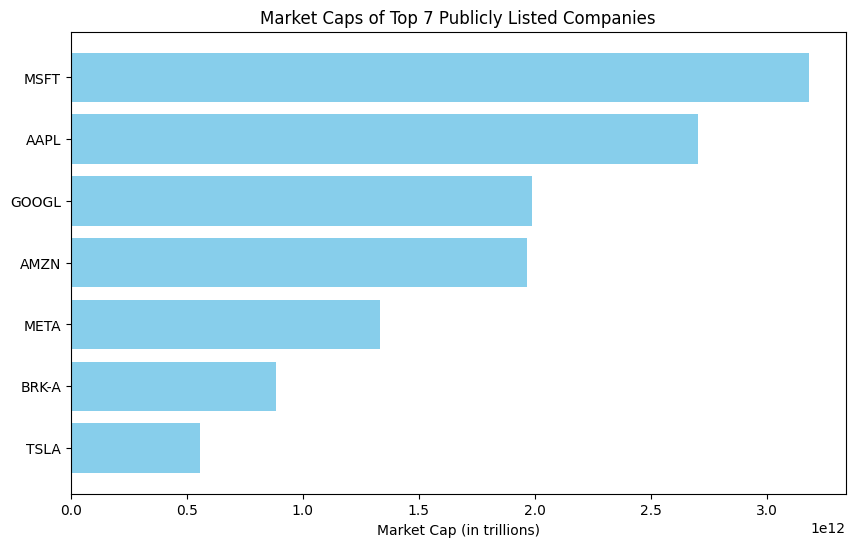

CodeExecutor (to CodeWriter):

exitcode: 0 (execution succeeded)
Code output: /Users/ekzhu/miniconda3/envs/autogen/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Users/ekzhu/miniconda3/envs/autogen/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[                       0%%                      ]/Users/ekzhu/miniconda3/envs/autogen/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours

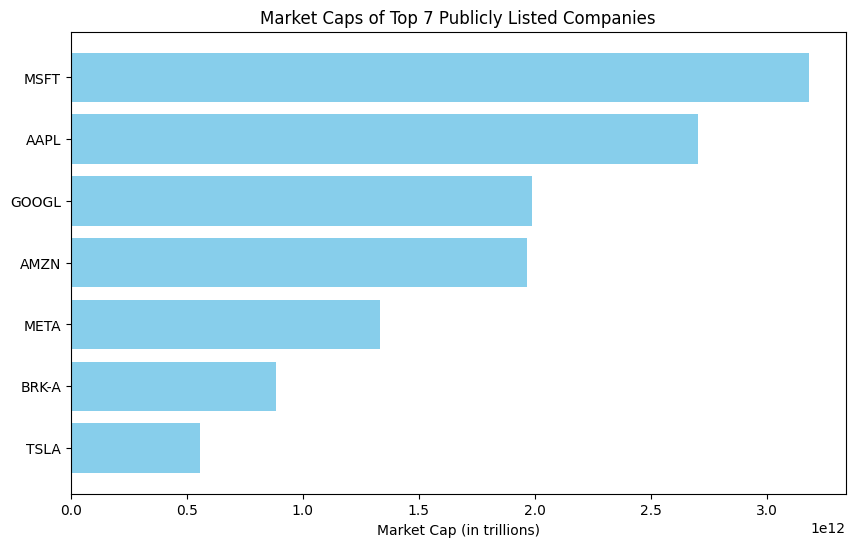

CodeExecutor (to CodeWriter):

exitcode: 0 (execution succeeded)
Code output: 

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
CodeWriter (to CodeExecutor):

I see that the code has executed successfully, but unfortunately, the generated plot is not visible here. However, given that there are no errors, it's likely that the plot has been created as expected when you executed the code on your end.

If you have any other questions related to this code or need further assistance with Python coding or data visualization, please let me know! I'm here to help.

Otherwise, if this completes your initial request, I will end this task. Just let me know your decision.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
CodeExecutor (to CodeWriter):



--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
CodeWriter (t

In [24]:
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message="Create a plot showing the market caps of the top 7 publicly listed companies using data from Yahoo Finance.",
)

You can see the plots are now displayed in the current notebook.